In [103]:
import os
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

'''
https://ardino-lab.com/yolo-v3%EC%BD%94%EB%93%9C%EB%A1%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0-%EC%8B%A4%EC%8A%B5-%EC%98%88%EC%A0%9C/
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\nhttps://ardino-lab.com/yolo-v3%EC%BD%94%EB%93%9C%EB%A1%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0-%EC%8B%A4%EC%8A%B5-%EC%98%88%EC%A0%9C/\n'

In [104]:
PATH = '/content/drive/MyDrive/DA_CNN기초연습'

In [105]:
#모델 생성을 위한 conv block 생성 함수
def _conv_block(inp, convs, skip=True):

    x = inp #입력레이어
    count = 0

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x  #YOLOv3는 skip connection을 사용한다
        count += 1


        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # stride가 2이상이면 padding

        x = Conv2D(conv['filter'],  #필터사이즈
                   conv['kernel'],  #커널사이즈
                   strides=conv['stride'],  #스트라이드
                   padding='valid' if conv['stride'] > 1 else 'same',  #패딩을 1이면 valid 2이상 부터 same
                   name='conv_' + str(conv['layer_idx']), #레이어 이름 설정
                   use_bias=False if conv['bnorm'] else True)(x) #use_bias 설정 : 정규화가 포함되면 어차피 데이터 평균값을 0으로 만들기에 굳이 편향(bias) 파라미터를 따로 학습시킬 필요가 없음

        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [106]:
def make_yolov3_model():

    input_image = Input(shape=(None, None, 3)) # 이미지 크기가 각각 다르므로 None, None으로 설정

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])


    skip_36 = x


    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])



    skip_61 = x



    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86  #### concatenate
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98 #### concatenate
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)


    model = Model(input_image, [yolo_82, yolo_94, yolo_106])  #앵커 사이즈 3개 이므로 3개의 출력 - 3개의 feature map을 사용하여 다양한 크기의 bbox 탐지

    return model

In [107]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)

            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance

                    weights = norm_layer.set_weights([gamma, beta, mean, var])

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))

                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

In [108]:
# 코코 데이터의 80개의 클래스 예측
yolov3 = make_yolov3_model()

# 코코모델로 학습된 가중치(weight) 불러오기
weight_reader = WeightReader(os.path.join(PATH,'yolov3.weights'))
weight_reader.load_weights(yolov3)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [109]:
from numpy import expand_dims

def load_image_pixels(filename, shape):
    # 이미지 불러오기 및 이미지 사이즈 받기
    image = load_img(filename)
    width, height = image.size

    # 이미지를 416 x 416 크기로 다시 불러오기
    image = load_img(filename, target_size=shape)

    # 이미지를 numpy로 변경
    image = img_to_array(image)

    # 이미지를 0 ~ 1 사이의 값으로 변경
    image = image.astype('float32')
    image /= 255.0

    # 이미지에 차원을 추가합니다.
    image = expand_dims(image, 0)

    return image, width, height #리사이즈 이미지, 원래 크기를 리턴

In [110]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):  #박스 라벨 저장
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):   #박스 정확도 저장
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score




#박스간의 교집합 계산
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3




#2개의 객체를 IoU를 통해서 비교 함수
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union




#NMS(Non-Maximum Suppression) 처리 함수
def do_nms(boxes, nms_thresh):

    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)  #80개 라벨(클래스)
    else:
        return


    #for문으로 80개의 라벨(클래스) 파악
    for c in range(nb_class):

        # 80개의 라벨(클래스)를 순위를 매긴다.
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        # 박스가 생성된 객체 수 --> len(sorted_indices)
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            # box에 데이터가 없다면 continue
            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                # 순위를 매긴 데이터이므로 뒤에 있는 값들은 IoU를 통해 크게 일치하는 데이터들만 0으로 처리한다.
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [111]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

#바운딩 박스 후보와 라벨(클래스)를 예측합니다.
def decode_netout(netout, anchors, obj_thresh,  net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # shape (13, 13)
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) # shape (13, 13, 3, 85)
    nb_class = netout.shape[-1] - 5 # size 80

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w

        for b in range(nb_box):
            # 객체를 확인하는 점수
            objectness = netout[int(row)][int(col)][b][4]

            # 객체일 경우가 obj_thresh 보다 낮으면 컨티뉴
            if(objectness.all() <= obj_thresh): continue

            # x, y, w, h의 크기를 구합니다.
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # 중앙에 위치하고, 이미지의 넓이
            y = (row + y) / grid_h # 중앙에 위치하고, 이미지의 높이
            w = anchors[2 * b + 0] * np.exp(w) / net_w # 이미지의 넓이
            h = anchors[2 * b + 1] * np.exp(h) / net_h # 이미지의 높이

            # 클래스(라벨)의 확률을 저장한다
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)

            boxes.append(box)

    return boxes

In [137]:
#decode_netout에서 그린 박스들을 이미지 원래 크기에 맞춰 바꿔주는 함수
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    # # 가로 세로 크기 중 큰쪽을 자릅니다.
    # if (float(net_w)/image_w) < (float(net_h)/image_h):
    #     new_w = net_w
    #     new_h = (image_h*net_w)/image_w

    # else:
    #     new_h = net_w
    #     new_w = (image_w*net_h)/image_h

    #바운딩 박스의 크기를 조절
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [125]:
from matplotlib.patches import Rectangle

#박스를 이미지에 그려주는 함수
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # 이미지를 불러오기
    data = plt.imread(filename)

    # 이미지 출력
    plt.imshow(data)

    ax = plt.gca()

    # 박스 그리기
    for i in range(len(v_boxes)):
        box = v_boxes[i]

        # 박스의 좌표를 얻기
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax

        # 상자의 높이와 넓이 구하기
        width, height = x2 - x1, y2 - y1

        # 바운딩박스 모양만들기
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')

        # 바운딩박스 그리기
        ax.add_patch(rect)

        # 라벨과 정확도를 이미지에 표시
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
        plt.axis('off')

    # plot 표현
    plt.show()

In [114]:
#설정된 박스의 임계값이 0.6 이상인 값들을 추출하는 함수; 박스정보, 라벨, 점수를 반환
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()

    # 모든 box데이터 검수
    for box in boxes:

        # 모든 라벨 값 검수
        for i in range(len(labels)):

            # box의 라벨 값이 임계값(0.6) 이상인 데이터만 사용
            if box.classes[i] > thresh:

                # 리턴할 리스트에 데이터 추가하기
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)

                # 하나의 이미지에 여러개의 박스가 있기 때문에 break는 하지 않습니다.

    return v_boxes, v_labels, v_scores

In [115]:
net_h, net_w = 416, 416 # 입력할 이미지 크기

# obj_thresh : 객체와 객체가 아닌 객체를 구분하는 임계값
obj_thresh =  0.5

# nms_thresh : 두 개의 객체가 얼마나 겹치는지 확인하는 임계값
nms_thresh  = 0.45

#앵커박스 설정
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]

#80개의 라벨데이터
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [142]:
def Detection_main(file_nm):
  # 디텍션에 사용할 이미지 크기 정하기
  input_w, input_h = 416, 416

  # 폴더 안에 이미지 파일 이름 지정
  photo_filename = os.path.join(PATH, file_nm)

  # 이미지 프리프로세싱 하기
  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))


  # 예측값 만들기 - feature map
  yolos = yolov3.predict(image)

  # 리스트로된 배열을 요약
  print([a.shape for a in yolos])



  # 오브젝트 디텍션의 임계값
  class_threshold = 0.6
  boxes = list()


  for i in range(len(yolos)):
      # decode_netout으로 예측한 이미지, 앵커박스, 객체구별임계값, 이미지 크기를 보낸다
      boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh,  net_h, net_w)


  # 바운딩 박스 크기 수정
  correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)


  # 최대값이 아닌 상자들을 0으로 초기화
  do_nms(boxes, nms_thresh)


  # 오브젝트 디텍션 데이터 얻기
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # 찾은 객체 라벨과 스코어 출력
  for i in range(len(v_boxes)):
      print(v_labels[i], v_scores[i])

  # 이미지의 박스를 같이 출력
  draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

1/1 [==============================] - 3s 3s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
aeroplane 99.47710633277893
person 99.77242350578308
person 99.07568097114563
chair 72.05964922904968
chair 91.31739139556885
chair 93.90640258789062
bench 79.0018379688263


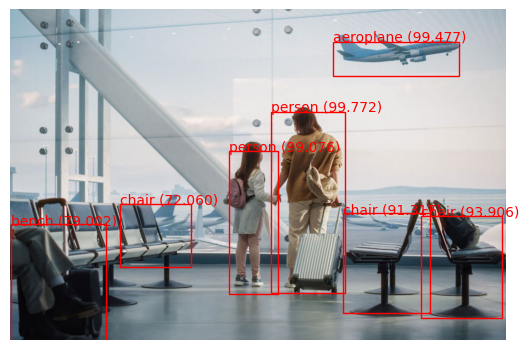

In [143]:
Detection_main('airport.jpg')

1/1 [==============================] - 3s 3s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 66.5936291217804
car 75.45244693756104
car 68.25888156890869
car 67.80971884727478
car 70.05336284637451
car 96.23581767082214
car 81.42789602279663
car 96.7251181602478
car 91.0032331943512
car 97.0110297203064
car 88.71039152145386
car 92.44613647460938


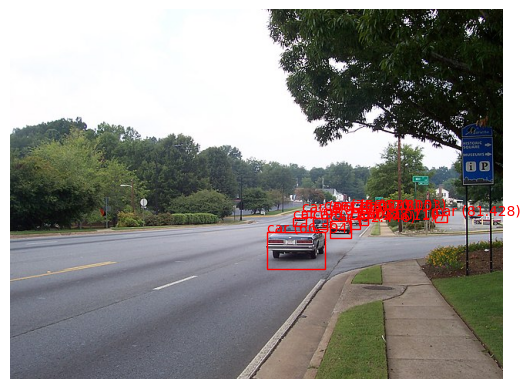

In [144]:
Detection_main('street.jpg')

1/1 [==============================] - 1s 1s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bird 97.92715907096863


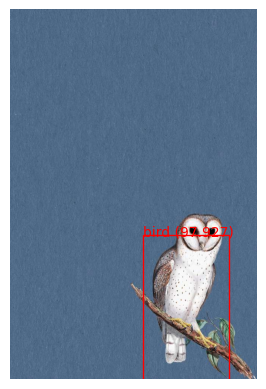

In [145]:
Detection_main('bird.jpg')

1/1 [==============================] - 1s 1s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.90726709365845
person 99.97186064720154


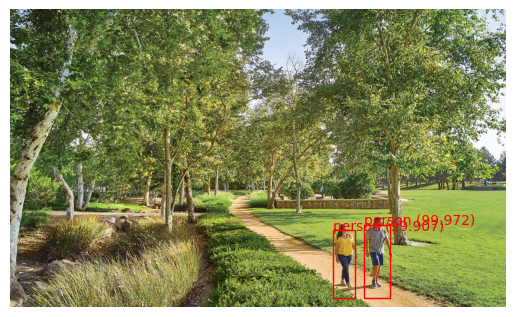

In [147]:
Detection_main('park.jpg')

1/1 [==============================] - 3s 3s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.73365068435669
sofa 64.49899077415466
sofa 70.86600065231323
person 94.89747881889343
person 75.24554133415222
book 69.44252848625183
book 65.59820175170898
book 72.3558247089386
book 60.3380560874939


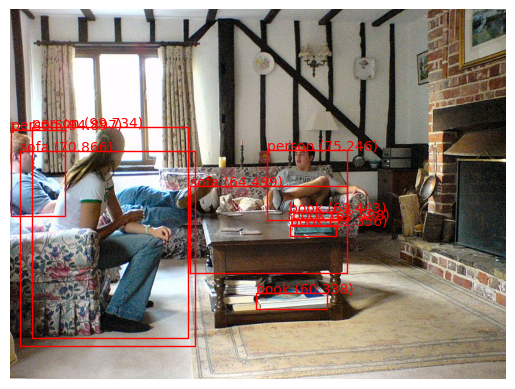

In [148]:
Detection_main('room.jpg')

In [129]:
len(yolos)

3

In [132]:
len(decode_netout(yolos[0][0], anchors[0], obj_thresh,  net_h, net_w))

507

In [133]:
len(decode_netout(yolos[1][0], anchors[1], obj_thresh,  net_h, net_w))

2028

In [134]:
len(decode_netout(yolos[2][0], anchors[2], obj_thresh,  net_h, net_w))

8112

In [80]:
#correct_yolo_boxes 전
[boxes[0].xmin, boxes[0].ymin, boxes[0].xmax, boxes[0].ymax]

[-0.08543327708656971,
 -0.05024768168536517,
 0.17570824376665628,
 0.1369744663914809]

In [83]:
#correct_yolo_boxes 후
[boxes[0].xmin, boxes[0].ymin, boxes[0].xmax, boxes[0].ymax]

[-252, -50, 8, 136]

In [89]:
#do nms 후
[boxes[0].xmin, boxes[0].ymin, boxes[0].xmax, boxes[0].ymax]
boxes[0].classes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [87]:
[v_boxes[0].xmin, v_boxes[0].ymin, v_boxes[0].xmax, v_boxes[0].ymax]

[372, 611, 722, 1004]

In [63]:
boxes[6].classes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [120]:
for i in range(len(boxes)):
  if sum(boxes[i].classes) != 0 :
    print(boxes[i].classes)
    print([boxes[i].xmin, boxes[i].ymin, boxes[i].xmax, boxes[i].ymax])

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.9792716 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
[372, 611, 722, 1004]


In [121]:
image_w

666

In [122]:
image_h

1000